In [2]:
library(tidyverse)
library(tidymodels)
library(repr)
library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(glmnet)
library(cowplot)
library(MASS)
library(boot)
library(caret)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Data Description
Our group's dataset, from The UCI Machine Learning Repository https://archive.ics.uci.edu/dataset/2/adult, is a set of 48,842 observations extracted from the 1994 World Census data for the purpose of predicting whether an adult earns more than $50,000 per year. Our dataset has a total of 15 variables, which are:

- **`age`**: The age of the adult. Quantitative variable
- **`workclass`**: Type of the adult's work (ex. Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked). Categorical variable.
- **`fnlwgt`**: final weight, the number of people the census believes this entry represents. Quantitative variable.
- **`education`**: The education level of adult (ex. Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.) Categorical variable.
- **`education-num`**: Integer education level. Quantitative variable.
- **`marital-status`**: Marital status of the adult (ex. Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse). Categorical variable.
- **`occupation`**: The occupation of the adult (ex. Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces). Categorical variable.
- **`relationship`**: Relationship in family (ex. Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried).  Categorical variable.
- **`race`**: The race of the adult (ex. White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black). Categorical variable.
- **`sex`**: The gender of the adult (ex. Female, Male). Categorical variable.
- **`capital-gain`**: The profit that results from a sale of a capital asset. Quantitative variable.
- **`capital-loss`**: The financial loss incurred when a capital asset decreases. Quantitative variable.
- **`hours-per-week`**: Hours of work per week. Quantitative variable.
- **`native-country`**: Citizenship of adult (ex. United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands). Categorical variable.
- **`income`**: Whether income exceeds $50,000 per year (ex. >50K, <=50K). Categorical variable.

In [3]:
#Read and tidy data
adult_test <- read.table("https://github.com/Haobo11/STAT301-Group-Project/raw/main/adult.test",  sep = "," , skip=1)
colnames(adult_test) <- c("age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
                          "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
                          "hours_per_week", "native_country", "income")
adult_test <- adult_test|>
    dplyr::select(- capital_gain, - capital_loss, - education_num)|> #Remove the capital_gain and capital_loss column, 
                                                 #since there are many missing value in thest two variable.
    mutate(workclass = factor(workclass), #Factor the categorical variable
           education = factor(education),
           marital_status = factor(marital_status),
           occupation = factor(occupation),
           relationship = factor(relationship),
           race = factor(race),
           sex = factor(sex),
           native_country = factor(native_country),
           income = factor(income))|>
    mutate(across(where(is.character), str_trim))|>
    filter(occupation!=" ?")|>
    filter(native_country!=" ?")|> #Filter the observation that have missing value
    filter(native_country == c(" United-States", " Canada", " Mexico", " Jamaica", " Cuba"))#Since our quetion focused on the data in North America, 
                                                                                             # we filter the North America Country in Dataset.
head(adult_test)

adult_data <- read.table("https://github.com/Haobo11/STAT301-Group-Project/raw/main/adult.data",  sep = ",")
colnames(adult_data) <- c("age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
                          "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
                          "hours_per_week", "native_country", "income")
adult_data <- adult_data|>
     dplyr::select(- capital_gain, - capital_loss,  - education_num)|> #Remove the capital_gain and capital_loss column, 
                                                 #since there are many missing value in thest two variable.
    mutate(workclass = factor(workclass),#Factor the categorical variable
           education = factor(education),
           marital_status = factor(marital_status),
           occupation = factor(occupation),
           relationship = factor(relationship),
           race = factor(race),
           sex = factor(sex),
           native_country = factor(native_country),
           income = factor(income))|>
    filter(occupation!=" ?") |>
    filter(native_country!=" ?")|> #Filter the observation that have missing value
    filter(native_country == c(" United-States", " Canada", " Mexico", " Jamaica", " Cuba")) #Since our quetion focused on the data in North America, 
                                                                                             # we filter the North America Country in Dataset.
head(adult_data)

,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income
,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>
1,25,Private,226802,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,40,United-States,<=50K.
2,63,Self-emp-not-inc,104626,Prof-school,Married-civ-spouse,Prof-specialty,Husband,White,Male,32,United-States,>50K.
3,26,Private,82091,HS-grad,Never-married,Adm-clerical,Not-in-family,White,Female,39,United-States,<=50K.
4,37,Private,60548,HS-grad,Widowed,Machine-op-inspct,Unmarried,White,Female,20,United-States,<=50K.
5,45,Self-emp-not-inc,432824,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,90,United-States,>50K.
6,46,State-gov,106444,Some-college,Married-civ-spouse,Exec-managerial,Husband,Black,Male,38,United-States,>50K.


Warning message:
“There were 2 warnings in `filter()`.
The first warning was:
ℹ In argument: `==...`.
Caused by warning in `==.default`:
! longer object length is not a multiple of shorter object length
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income
,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>
1,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,<=50K
2,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,<=50K
3,37,Private,284582,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,40,United-States,<=50K
4,37,Private,280464,Some-college,Married-civ-spouse,Exec-managerial,Husband,Black,Male,80,United-States,>50K
5,25,Self-emp-not-inc,176756,HS-grad,Never-married,Farming-fishing,Own-child,White,Male,35,United-States,<=50K
6,54,Private,302146,HS-grad,Separated,Other-service,Unmarried,Black,Female,20,United-States,<=50K


## Research Question:
1) How age, fnlwgt, educational number, marital_status, hours_per_week, occupation, race and sex correlated to adult annual income in North America?

2) Which condition factors, when used as explanatory variables, create the model that yields the most accurate real-time predictions of adult annual income in North America?

## Visualization
#### Quantitative Variable
In analyzing the correlation between quantitative variables such as age, fnlwgt, education_num, and hours_per_week with annual income, we'll utilize side-by-side boxplots to effectively visualize these relationships with the binary income variable.

Side-by-side boxplots are particularly insightful, as they allow us to directly compare the central tendencies and variabilities between groups classified by income levels "<=50K" and ">50K". This visualization will enable us to discern the differences in medians, examine the interquartile ranges, and spot any outliers or data anomalies that could influence the income variable.

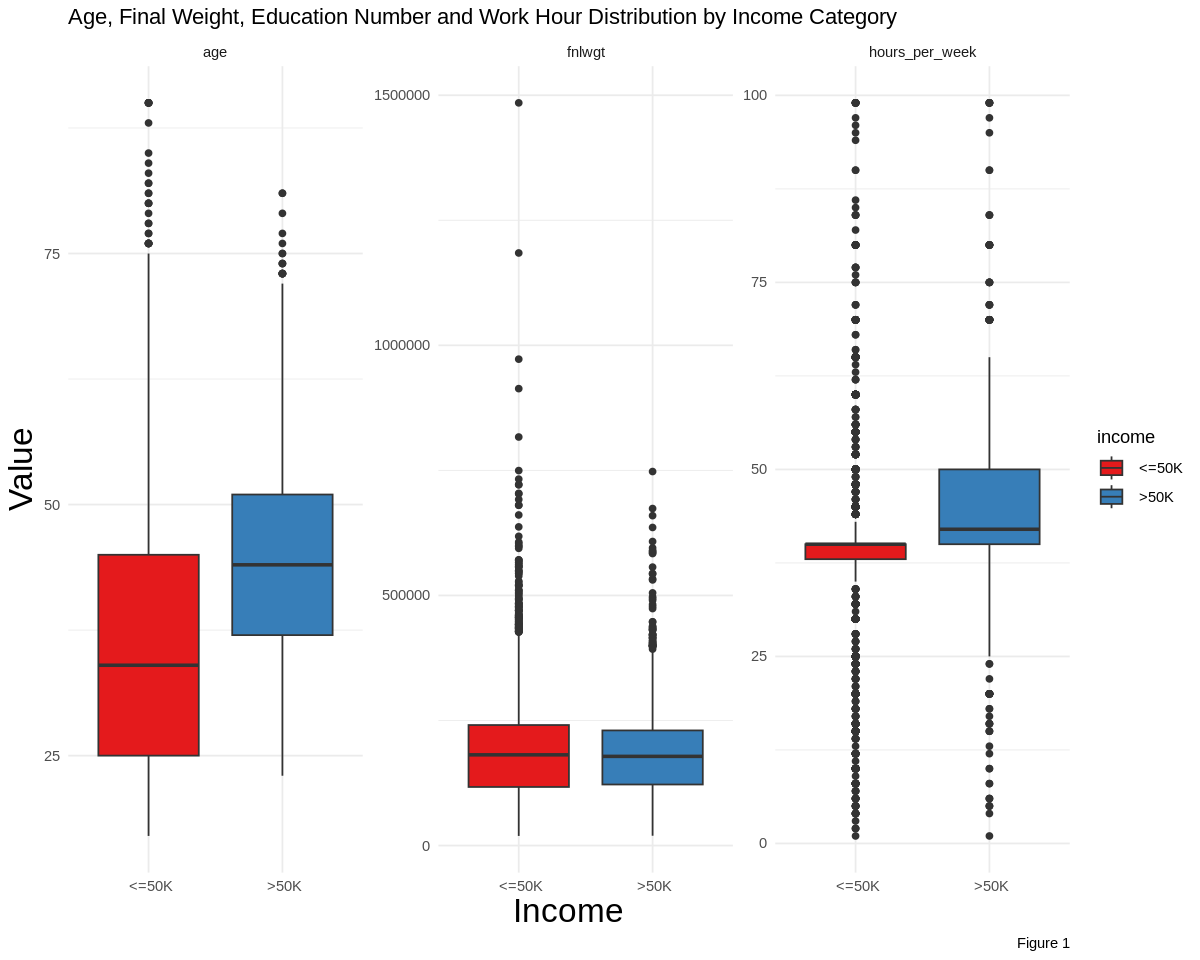

In [4]:
long_adult_data <- adult_data %>%
  pivot_longer(cols = c(age, fnlwgt, hours_per_week), 
               names_to = "variable", 
               values_to = "value")

options(repr.plot.width = 10, repr.plot.height = 8)
combo_boxplot <- ggplot(long_adult_data, aes(x = income, y = value, fill = income)) +
  geom_boxplot() +
  facet_wrap(~ variable, scales = "free") + 
  theme_minimal() +
  labs(title = "Age, Final Weight, Education Number and Work Hour Distribution by Income Category",
       x = "Income",
       y = "Value",
      caption="Figure 1") +
  scale_fill_brewer(palette = "Set1") +
  theme(axis.title = element_text(size = 20))
combo_boxplot

**Interpretation:**
- **Age**: From the boxplot, we can observe that the median age of the >50K income group is higher than that of the <=50K group. This suggests that higher income is associated with older age, which might reflect career progression and accumulation of experience leading to higher earnings.
- **Final Weight (fnlwgt)**: The variable seems to have a wide range of values with numerous outliers in both income categories. The distribution does not seem to differ much between the two income groups, implying that this variable may not be a strong predictor of income.
- **Hours per Week**: Individuals earning >50K appear to work more hours per week than those earning <=50K, suggesting that income could be positively correlated with the amount of work done.

From the visualization, we can deduce that age, education level, and hours per week are potentially useful predictors of income since their distributions vary significantly between the two income groups. While the fnlwgt's role is less clear from this visualization alone, it might not be as strong a predictor in isolation.

#### Categorical Variable
According to our Question 1, in analyzing the correlation between categorical variables such as  marital_status, native_country, race and sex with annual income in North America, we'll utilize bar plot to effectively visualize these relationships with the binary income variable. Since bar plots are useful for displaying the relationship between two categorical variables because they visually show the frequency or proportion of cases for each category combination. 

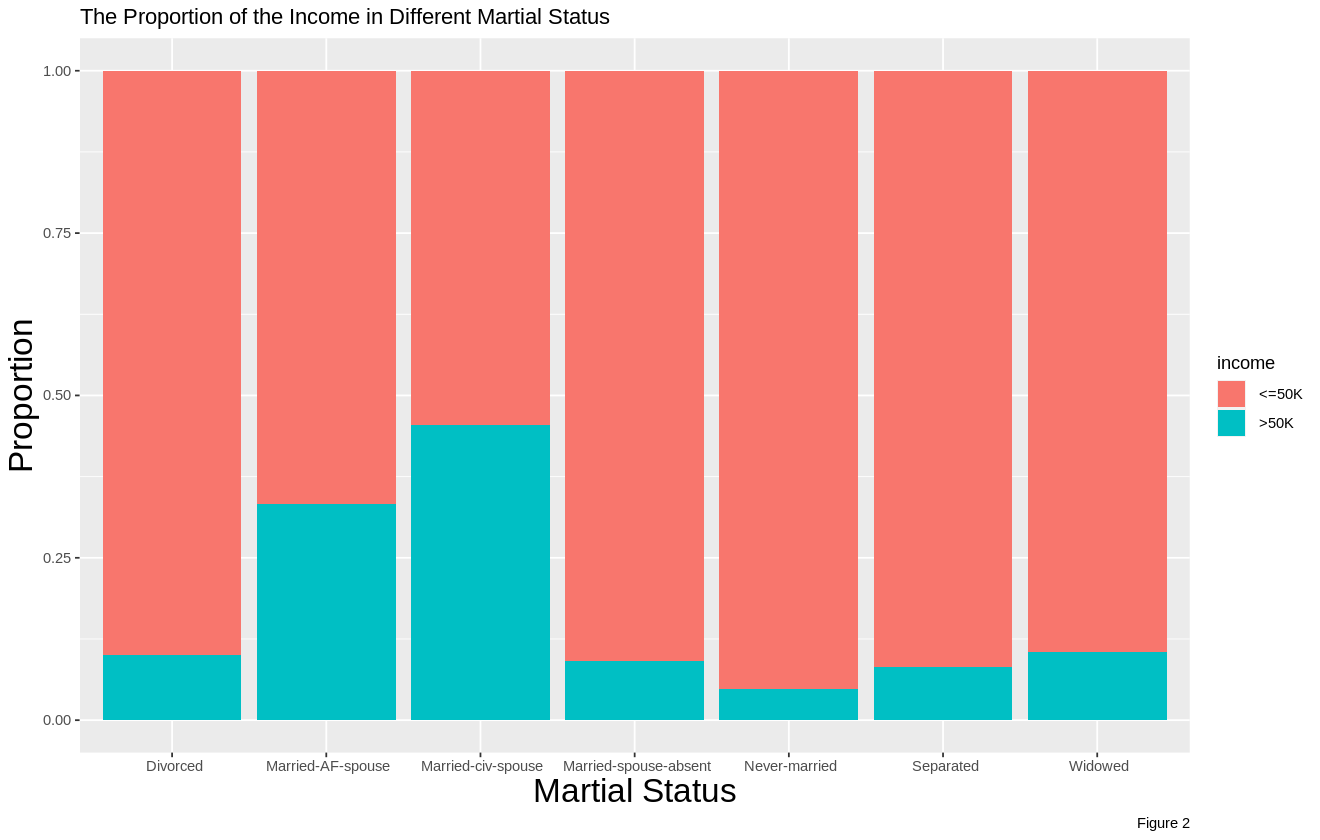

In [5]:
options(repr.plot.width = 11, repr.plot.height = 7)
bar_marital_status_vs_income <- adult_data|>
ggplot(aes(x = marital_status, fill = income)) +
  geom_bar(position = 'fill') + 
  labs(title="The Proportion of the Income in Different Martial Status",
      y="Proportion",
      x= "Martial Status",
      caption="Figure 2")+
    theme(axis.title = element_text(size = 20))
bar_marital_status_vs_income

**Interpretation:**
- This bar chart represents the proportion of individuals within various racial groups who earn <=50K and >50K. Marriage, specifically to a civilian spouse, seems to be correlated with a higher likelihood of earning >50K, while being divorced, separated, never-married, or widowed is associated with a higher likelihood of earning <=50K. The Armed Forces spouse category is less clear due to its balanced distribution.
- Marital status seems to be a significant factor when predicting income. Since the categories within marital status have different proportions of income distribution, this variable can potentially contribute to the accuracy of a predictive model. 
- The marital status variable has numerous levels, which could lead to a model with excessive complexity if each level is treated as a separate category. This complexity can make the model difficult to interpret and might also increase the risk of overfitting, where the model becomes too tailored to the idiosyncrasies of the training data, reducing its generalizability to new data. Therefore we consider combine the levels as married and other than married in the furture modeling and analysis.

## Method and Plan
Based on our research question: Which condition factors, when used as explanatory variables, create the model that yields the most accurate real-time predictions of adult annual income in North America? For the predictive model, we intend to use Stepwise selection with the BIC (Bayesian information criterion) to select the most appropriate logistic regression model, because a smaller AIC value represents a better ability to match the model to the data.

#### Why Logistic Regression is Appropriate
- Since our response variable (income) is binary (<=50K, >50K), making logistic regression a suitable choice as it is designed for binary outcomes. And logistic regression can handle both categorical (marital_status, native_country, race, sex) and continuous predictors (age, fnlwgt, educational number, hours_per_week), which matches our dataset. It allows us to estimate the probability of an individual falling into a particular income category, which is useful for prediction.
#### Why Stepwise Selection is Appropriate
- Stepwise selection simplifies the model-building process by automating the selection of significant variables, which is particularly useful when there are many potential predictors and no clear indication of the most important ones. And it combines both forward and backward selection methods, adding variables that provide a significant contribution to the model and removing those that do not.
- By iteratively considering the statistical significance of each variable, stepwise selection seeks to optimize the model by including only those variables that have a justifiable impact on the response variable, potentially leading to a model that balances complexity and performance.
#### Assumptions Required
- Linearity of Logit: There should be a linear relationship between the logit of the outcome and each predictor variable. 
- No multicollinearity: It assumes that the predictors are not highly correlated with each other.
- Independence: Observations are assumed to be independent and independence of errors.
- Large Sample Size: Logistic regression typically requires a large sample size to predict accurately. 

#### Potential Limitations or Weaknesses:
- Overfitting: Stepwise methods can lead to overfitting the model to the data, especially when the number of observations is not much larger than the number of potential predictors.
- P-Value Limitations: The use of p-values as the sole criterion for variable inclusion can be problematic, especially considering that p-values are sensitive to sample size.
- Biased Parameter Estimates: Stepwise selection can produce biased parameter estimates, especially when the true model is not nested within the set of models considered by the stepwise procedure.
- Model Stability: The final model can be sensitive to small changes in the data, meaning that different datasets can lead to different selected models.
- Ignoring Model Hierarchies: Stepwise selection might add or remove predictors without respect for certain hierarchies or theories that may be important (e.g., it might include an interaction term without including the main effects).
- Multiple Testing Problem: Each step involves multiple hypothesis tests, leading to an increased risk of Type I errors (false positives).
- Stepwise methods only partial contribution of variables is considered.
- Stepwise methods once variables are selected they are not re-evaluated.
- Stepwise methods can't be used when $n < p$.

## Implementation of a proposed model

In [3]:
# Assuming adult_data is our training dataset and adult_test is our testing dataset
adult_data <- 
    adult_data %>% 
    mutate(income = ifelse(income == " >50K", 1, 0))
head(adult_data)

adult_test <- 
    adult_test %>% 
    mutate(income = ifelse(income == " >50K.", 1, 0))
head(adult_test)

,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income
,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>
1,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,0
2,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,0
3,37,Private,284582,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,40,United-States,0
4,37,Private,280464,Some-college,Married-civ-spouse,Exec-managerial,Husband,Black,Male,80,United-States,1
5,25,Self-emp-not-inc,176756,HS-grad,Never-married,Farming-fishing,Own-child,White,Male,35,United-States,0
6,54,Private,302146,HS-grad,Separated,Other-service,Unmarried,Black,Female,20,United-States,0


,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income
,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>
1,25,Private,226802,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,40,United-States,0
2,63,Self-emp-not-inc,104626,Prof-school,Married-civ-spouse,Prof-specialty,Husband,White,Male,32,United-States,1
3,26,Private,82091,HS-grad,Never-married,Adm-clerical,Not-in-family,White,Female,39,United-States,0
4,37,Private,60548,HS-grad,Widowed,Machine-op-inspct,Unmarried,White,Female,20,United-States,0
5,45,Self-emp-not-inc,432824,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,90,United-States,1
6,46,State-gov,106444,Some-college,Married-civ-spouse,Exec-managerial,Husband,Black,Male,38,United-States,1


In [4]:
# Fitting the logistic regression model with stepwise selection using BIC
full_model <- glm(income ~ ., data = adult_data, family = binomial())
full_model_result<-tidy(full_model)
full_model_result
stepwise_model <- stepAIC(full_model, direction = "both", trace = FALSE, k = log(nrow(adult_data)))

# Summarizing the model
summary(stepwise_model)

# Predicting and evaluating on the test set
predictions <- round(predict(stepwise_model, newdata = adult_test, type = "response"),0)

# Use the confusionMatrix function from the caret package
adult_income_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(predictions),
    reference = as.factor(adult_test$income),
    positive = "1"
)
adult_income_confusion_matrix

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-7.519090e+00,1.141229e+00,-6.58858832,4.440281e-11
age,3.613819e-02,3.748667e-03,9.64027886,5.404097e-22
workclass Local-gov,-7.412341e-01,2.432187e-01,-3.04760267,2.306747e-03
workclass Private,-5.104504e-01,2.009162e-01,-2.54061399,1.106580e-02
workclass Self-emp-inc,-8.410483e-02,2.630617e-01,-0.31971526,7.491842e-01
workclass Self-emp-not-inc,-1.136948e+00,2.408928e-01,-4.71972447,2.361643e-06
workclass State-gov,-9.315940e-01,2.721320e-01,-3.42331652,6.186200e-04
workclass Without-pay,-1.447178e+01,8.341511e+02,-0.01734911,9.861581e-01
fnlwgt,7.282897e-07,3.811272e-07,1.91088360,5.601954e-02


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Call:
glm(formula = income ~ age + education + occupation + relationship + 
    sex + hours_per_week, family = binomial(), data = adult_data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.61237  -0.58563  -0.21380  -0.00005   3.11921  

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -5.701e+00  4.776e-01 -11.936  < 2e-16 ***
age                           3.610e-02  3.506e-03  10.298  < 2e-16 ***
education 11th               -3.385e-01  4.988e-01  -0.679  0.49733    
education 12th                2.880e-01  6.723e-01   0.428  0.66835    
education 1st-4th            -7.738e-01  1.107e+00  -0.699  0.48441    
education 5th-6th            -1.368e+01  3.131e+02  -0.044  0.96514    
education 7th-8th            -6.195e-01  5.080e-01  -1.220  0.22260    
education 9th                 2.214e-01  5.584e-01   0.397  0.69171    
education Assoc-acdm          1.050e+00  4.115e-01   2.551  0.01074 * 

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1931  317
         1  177  408
                                          
               Accuracy : 0.8256          
                 95% CI : (0.8111, 0.8394)
    No Information Rate : 0.7441          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5112          
                                          
 Mcnemar's Test P-Value : 4.003e-10       
                                          
            Sensitivity : 0.5628          
            Specificity : 0.9160          
         Pos Pred Value : 0.6974          
         Neg Pred Value : 0.8590          
             Prevalence : 0.2559          
         Detection Rate : 0.1440          
   Detection Prevalence : 0.2065          
      Balanced Accuracy : 0.7394          
                                          
       'Positive' Class : 1               
                        

### Interpretation
The logistic regression model demonstrates a good level of accuracy (82.56%) in predicting adult annual income in North America, indicating its effectiveness in distinguishing between income levels. However, the moderate Kappa value (0.5112) suggests only moderate agreement beyond chance, and the difference between sensitivity (56.28%) and specificity (91.60%) highlights a potential bias towards predicting lower income levels more accurately. These results suggest the model's utility in addressing the research question but also point towards the need for further refinement, possibly by re-evaluating variable selection or employing techniques like ROC curve analysis to adjust decision thresholds for better balance in predictive performance. Incorporating cross-validation could enhance model robustness and generalization, reducing the risk of overfitting and providing a more balanced prediction for both income classes. 